# Ник aminovrustam, позиция 2

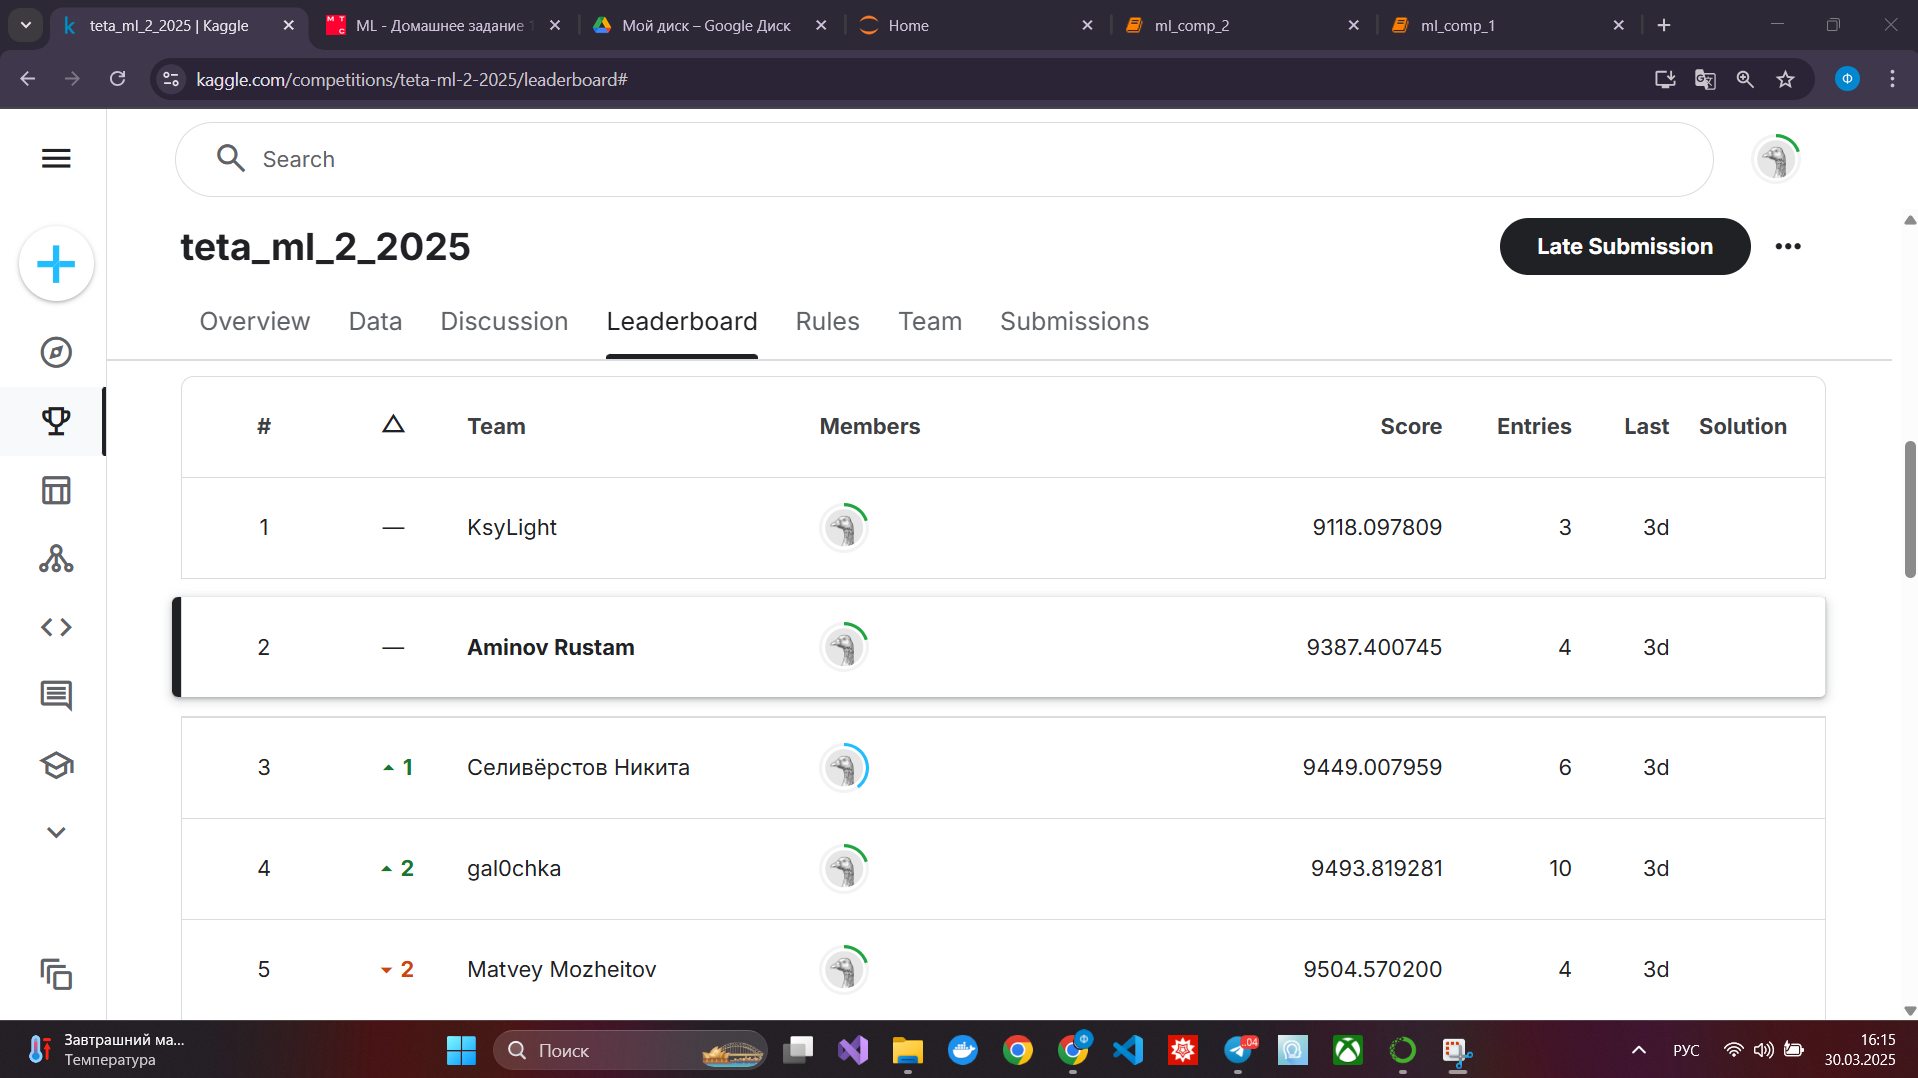

# Intro

1) **Обработка данных**:
Первым делом я проверил данные на наличие пропусков.
    - В колонке *name* и *hostname* были пропуски, я решил заполнить их значениями "NoName".
    - В колонке *last_dt* и *avg_reviews* были пропуски, это было взаимосвязано, если в *last_dt* был пропуск, то и в *avg_reviews* был пропуск. Я решил заменить пропуски в last_dt максимальным значением этой колонки, симетировав дату добавления в базу дома, который был добавлен совсем недавно. В *avg_reviews* (средний отзыв) я поставил единицу, это позволило сформировать новую фичу *reviews* расчитанную как умножение значений среднего отзыва и количество отзывов. Несмотря на то, что дома с этимим пропусками имеют средний отзыв - 0, это не значит, что они будут иметь низкую оценку, поэтому такой способ помог лучше описать дома без отзывов, благодаря признаку *reviews* дома, которые не имеют отзывов имеют сумму всех отзывов ноль и самую новую дату добавления.

    Рассмотрел распределение таргета и заметил, что в таргете много нулей и будет проблематично приводить его к распределению похожему на нормальное.

    После этого я проверил непрерывные признаки на наличие выбросов при помощи *zscore*. Добавил новые признаки:
   - *bearing_degree_1* - угол между прямой ((lat, lon),(0, 0)) и нулевой меридианой
    - *hav_dist_1* - расстояние от точки (lat, lon) до точки (0, 0)
    - *loc+cluster* - фича в которой я объединил название локации и кластера дома
    - *review* - фича описанная выше
    После этого я использовал алгоритм *backward_selection* для определения признаков, которые можно удалить для улучшения уменьшения метрики MSE.

3) **Алгоритм**:
Убедившись в удобности обработки категориальных признаков библиотекой *catboost* в первом соревновании, я сразу выбрал модель *CatBoostRegressor*. Так же организовал ансамбль из 7 моделей, обученных на разных объектах выборки разделенных посредством *StratifiedKFold*. Сохранил лучшие трешхолды и далее формировал ответы на основе этих предсказаний двумя следующими способами:

    - формировал конечный ответ, считая среднее между всеми семи ответами
    - формировал конечный ответ, находя медиану между всеми

    Оба эти способа достигали значения метрики MSE на тестовой выборке из обучающей и на сабмите меньше, чем единичная модель, поэтому я оставил ансамбль с двумя способами формированием ответа, так как kaggle позволяет выбирать два сабмита на конечном лидерборде.

3) **Особенности при обучении**:
Я использовал возможность бибилиотеки *catboost* автоматической обработки категориальных признаков. Коэффициент регуляризации *L2* 0.1 и *learning_rate* 0.1.

5) **Валидация алгоритма**:
После обучение ансамбля брал тестовую выборку из тренировочной и смотрел значение метрики MSE между таргетом из этой тестовой выборки и ответами, которые получились после голосования ансамбля (отложенная выборка).

Стоит сказать , что проведя эти действия, получилось попасть на хорошую позицию в лидерборде (1/2), поэтому я сфокусировался на улучшение решения для первого соревнования и не добавлял новые признаки или преобразовывал таргет.

# Загрузка данных

In [107]:
import pandas as pd
import numpy as np
import mplcyberpunk
plt.style.use("cyberpunk")
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [108]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [109]:
train.head(1)

,name,_id,host_name,location_cluster,location,lat,lon,type_house,sum,min_days,amt_reviews,last_dt,avg_reviews,total_host,target
0,Belle Harbor 4 BR 2 bath- 1 bl from Beach,40327248,Sarina,Queens,Neponsit,40.57215,-73.85822,Entire home/apt,350,2,5,2019-07-07,2.88,1,334


# Обработка данных

Распределение таргета

Text(0, 0.5, 'Дни занятости')

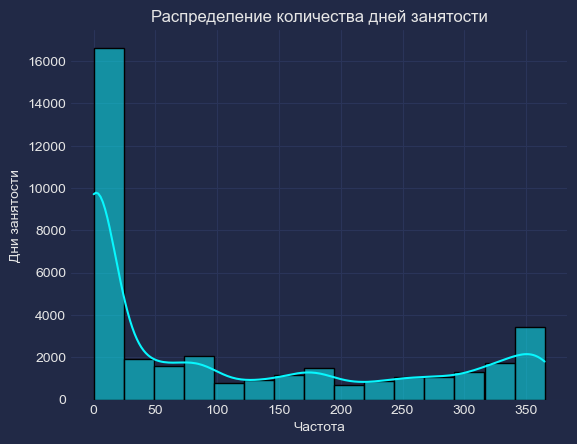

In [110]:
sns.histplot(train['target'], bins=15, kde=True)
plt.title('Распределение количества дней занятости')
plt.xlabel('Частота')
plt.ylabel('Дни занятости')

In [111]:
train.isna().sum()

name                   9
_id                    0
host_name             18
location_cluster       0
location               0
lat                    0
lon                    0
type_house             0
sum                    0
min_days               0
amt_reviews            0
last_dt             7502
avg_reviews         7502
total_host             0
target                 0
dtype: int64

In [112]:
test.isna().sum()

name                   7
_id                    0
host_name              3
location_cluster       0
location               0
lat                    0
lon                    0
type_house             0
sum                    0
min_days               0
amt_reviews            0
last_dt             2550
avg_reviews         2550
total_host             0
dtype: int64

In [31]:
print(f'Средние отзывы домов у которых нет отзывов: {train.loc[train['avg_reviews'].isna(), ['amt_reviews']].sum().values[0]}, средние оценки домов для домов без даты добавления: {train.loc[train['last_dt'].isna(), ['amt_reviews']].sum().values}')

Средние отзывы домов у которых нет отзывов: 0, средние оценки домов для домов без даты добавления: [0]


In [30]:
print(f'Средние отзывы домов у которых нет отзывов: {test.loc[test['avg_reviews'].isna(), ['amt_reviews']].sum().values[0]}, средние оценки домов для домов без даты добавления: {test.loc[test['last_dt'].isna(), ['amt_reviews']].sum().values[0]}')

Средние отзывы домов у которых нет отзывов: 0, средние оценки домов для домов без даты добавления: 0


In [37]:
(
    train.loc[train['avg_reviews'].isna(), 'last_dt'].unique(), 
    train.loc[train['last_dt'].isna(), 'avg_reviews'].unique()
)

(array([nan], dtype=object), array([nan]))

In [38]:
(
    test.loc[test['avg_reviews'].isna(), 'last_dt'].unique(), 
    test.loc[test['last_dt'].isna(), 'avg_reviews'].unique()
)

(array([nan], dtype=object), array([nan]))

Есть пропуски в отзывах, идея - заполнить единицами, но потом сделать новую колонку 'reviews' где я перемножу количество отзывов на их среднее значение. Плюс можно поиграться с этой единицей

In [53]:
train['last_dt_dt']=pd.to_datetime(train['last_dt'])
test['last_dt_dt']=pd.to_datetime(test['last_dt'])

In [54]:
train['last_dt_dt']=train['last_dt_dt'].fillna(train['last_dt_dt'].max())
test['last_dt_dt']=test['last_dt_dt'].fillna(test['last_dt_dt'].max())

In [55]:
train['ts_last_dt'] = pd.to_datetime(train['last_dt_dt']).values.astype('int64') // 10**9
test['ts_last_dt'] = pd.to_datetime(test['last_dt_dt']).values.astype('int64') // 10**9

Host name работа с ним

In [56]:
train['host_name']=train['host_name'].fillna('No_host')
test['host_name']=test['host_name'].fillna('No_host')

In [57]:
train['avg_reviews']=train['avg_reviews'].fillna(1.)
test['avg_reviews']=test['avg_reviews'].fillna(1.)

In [58]:
train['name']=train['name'].fillna('NoName')
test['name']=test['name'].fillna('NoName')

## Проверка выбросов

In [59]:
num_columns=train.drop(columns=['target', '_id']).select_dtypes(['int32', 'int64', 'float64']).columns

In [60]:
num_columns

Index(['lat', 'lon', 'sum', 'min_days', 'amt_reviews', 'avg_reviews',
       'total_host', 'ts_last_dt'],
      dtype='object')

lat Обучающая выборка 77 Тестирующая выборка 21


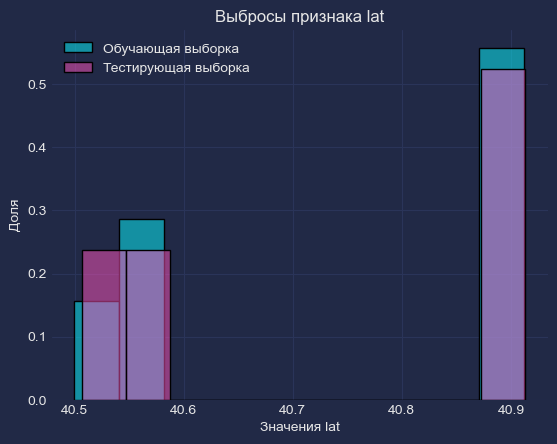

lon Обучающая выборка 916 Тестирующая выборка 320


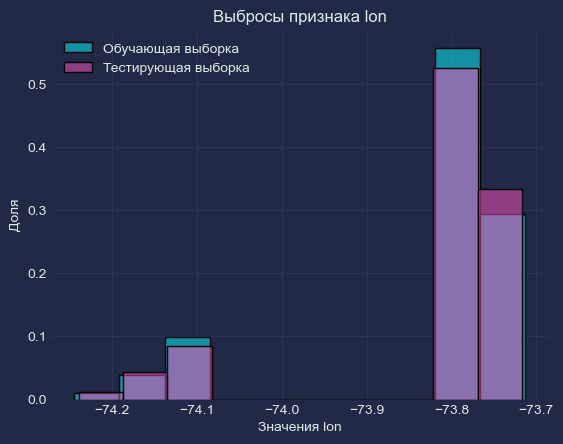

sum Обучающая выборка 284 Тестирующая выборка 104


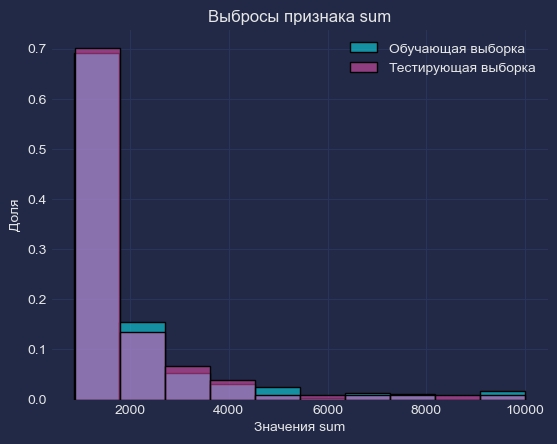

min_days Обучающая выборка 242 Тестирующая выборка 110


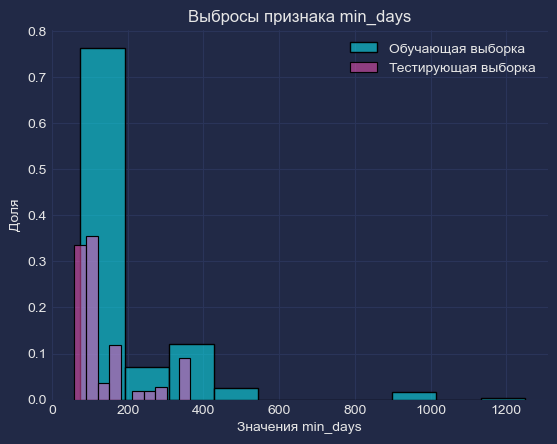

amt_reviews Обучающая выборка 915 Тестирующая выборка 292


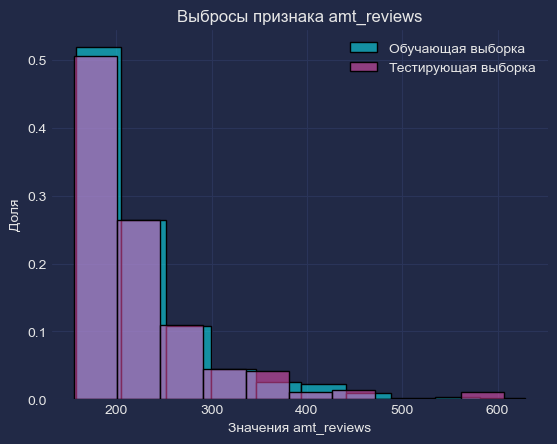

avg_reviews Обучающая выборка 700 Тестирующая выборка 187


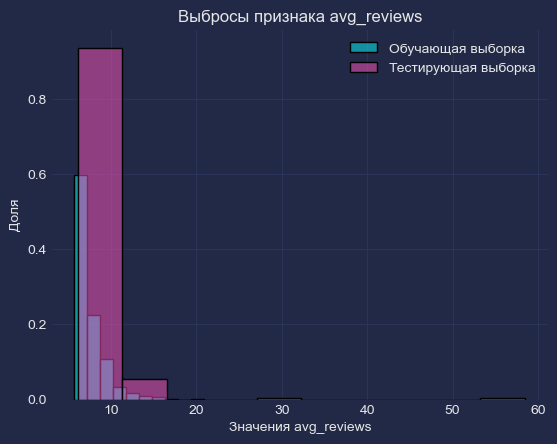

total_host Обучающая выборка 493 Тестирующая выборка 187


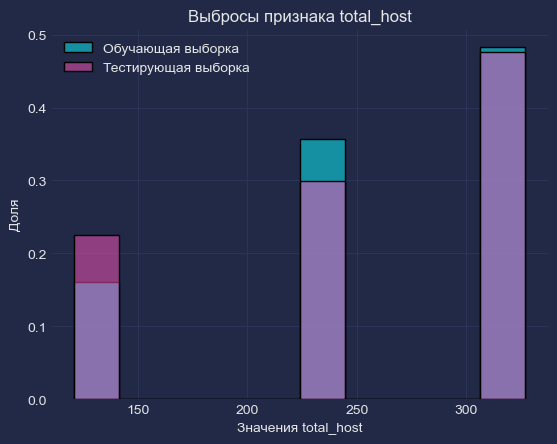

ts_last_dt Обучающая выборка 830 Тестирующая выборка 257


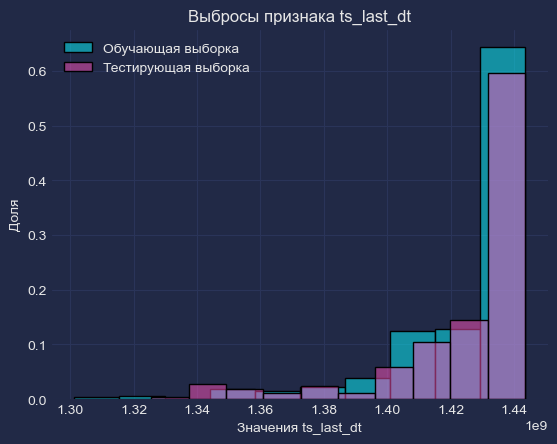

In [61]:
for column in num_columns:
    mask_outliesr_train = np.abs(zscore(train[column].values)) >= 3
    mask_outliesr_test = np.abs(zscore(test[column].values)) >= 3

    if(sum(mask_outliesr_train)!=0 and sum(mask_outliesr_test) != 0):
        print(
          column,
          'Обучающая выборка', sum(mask_outliesr_train),
          'Тестирующая выборка', sum(mask_outliesr_test),
        )
    
        sns.histplot(train[mask_outliesr_train][column], stat="probability", bins=10, alpha=0.5, label='Обучающая выборка')
        sns.histplot(test[mask_outliesr_test][column], stat="probability", bins=10, alpha=0.5, label='Тестирующая выборка')
        plt.legend()
        plt.ylabel('Доля')
        plt.xlabel(f'Значения {column}')
        plt.title(f'Выбросы признака {column}')
        plt.show()

**Вывод:** визуально видно, что есть разница между *train* и *test* в выбросах признаке *min_days*

In [62]:
for column in num_columns:
    mask_outliesr_train = np.abs(zscore(train[column].values)) >= 3
    mask_outliesr_test = np.abs(zscore(test[column].values)) >= 3

    if(sum(mask_outliesr_train)==0 and sum(mask_outliesr_test) == 0):
        print(f'В признаке {column} нет выбросов')
        

# Новые фичи

Локация и кластер

In [63]:
train['loc+clust']=train['location_cluster']+'_'+train['location']
test['loc+clust']=test['location_cluster']+'_'+test['location']

Работа с геоданными

In [64]:
def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float, n_digits: int = 0) -> float:
    """
        Функция для расчёта расстояния от точки А до Б по прямой

        :param lat1: Широта точки А
        :param lon1: Долгота точки А
        :param lat2: Широта точки Б
        :param lon2: Долгота точки Б
        :param n_digits: Округляем полученный ответ до n знака после запятой
        :return: Дистанция по прямой с точностью до n_digits
    """

    lat1, lon1, lat2, lon2 = round(lat1, 6), round(lon1, 6), round(lat2, 6), round(lon2, 6)
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)

    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2

    return round(2 * 6372800 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)), n_digits)  # метры.сантиметры


def bearing_degree(lat1: float, lon1: float, lat2: float, lon2: float, n_digits: int = 0) -> float:
    """
        Функция для расчёта угла между прямой [((lat1, lon1), (lat2, lon2)), (нулевой мередиан)]

        :param lat1: Широта точки А
        :param lon1: Долгота точки А
        :param lat2: Широта точки Б
        :param lon2: Долгота точки Б
        :param n_digits: Округляем полученный ответ до n знака после запятой
        :return: Значение угла с точностью до n_digits
    """

    lat1, lon1 = np.radians(round(lat1, 6)), np.radians(round(lon1, 6))
    lat2, lon2 = np.radians(round(lat2, 6)), np.radians(round(lon2, 6))

    dlon = (lon2 - lon1)
    numerator = np.sin(dlon) * np.cos(lat2)
    denominator = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(dlon))

    theta = np.arctan2(numerator, denominator)
    theta_deg = (np.degrees(theta) + 360) % 360

    return round(theta_deg, n_digits)

In [65]:
train['bearing_degree_1'] = bearing_degree(train['lat'], train['lon'], 0, 0, ).values
test['bearing_degree_1'] = bearing_degree(test['lat'], test['lon'], 0, 0, ).values

In [66]:
train['hav_dist_1'] = haversine_distance(train['lat'], train['lon'], 0, 0, ).values
test['hav_dist_1'] = haversine_distance(test['lat'], test['lon'], 0, 0, ).values

Работа с отзывами

In [67]:
train['reviews'] = train['avg_reviews']*train['amt_reviews']

In [68]:
test['reviews'] = test['avg_reviews']*test['amt_reviews']

# Тест модели и features importance

In [69]:
train.head(1)

,name,_id,host_name,location_cluster,location,lat,lon,type_house,sum,min_days,...,last_dt,avg_reviews,total_host,target,last_dt_dt,ts_last_dt,loc+clust,bearing_degree_1,hav_dist_1,reviews
0,Belle Harbor 4 BR 2 bath- 1 bl from Beach,40327248,Sarina,Queens,Neponsit,40.57215,-73.85822,Entire home/apt,350,2,...,2019-07-07,2.88,1,334,2019-07-07,1562457600,Queens_Neponsit,101.0,8654374.0,14.4


In [74]:
(train[num_columns].isna().sum().sum(), test[num_columns].isna().sum().sum())

(0, 0)

In [71]:
cat_columns = [
    'name',
    'host_name',
    'location_cluster',
    'location',
    'type_house',
    'loc+clust'
    ]

num_columns = [
    'lat',
    'lon',
    'sum',
    'min_days',
    'amt_reviews',
    'avg_reviews',
    'total_host',
    'bearing_degree_1',
    'hav_dist_1',
    'reviews',
    'ts_last_dt'
]

In [72]:
fin_mod_features = [
    'name',
    'host_name',
    'location_cluster',
    'location',
    'type_house',
    'loc+clust',
    'lat',
    'lon',
    'sum',
    'min_days',
    'amt_reviews',
    'avg_reviews',
    'total_host',
    'bearing_degree_1',
    'hav_dist_1',
    'reviews',
    'ts_last_dt'
]

In [75]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [77]:
X_train, X_test, y_train, y_test = train_test_split(
    train[fin_mod_features], train['target'], test_size=0.25, random_state=42
)

In [102]:
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=5, custom_metric='RMSE', l2_leaf_reg=0.1)

model.fit(X_train, y_train, cat_features=cat_columns, eval_set=(X_test, y_test))

0:	learn: 127.6463788	test: 128.9795228	best: 128.9795228 (0)	total: 68.6ms	remaining: 1m 8s
1:	learn: 124.6105524	test: 126.0240607	best: 126.0240607 (1)	total: 113ms	remaining: 56.3s
2:	learn: 122.2007124	test: 123.6652209	best: 123.6652209 (2)	total: 148ms	remaining: 49.3s
3:	learn: 120.0607575	test: 121.6105626	best: 121.6105626 (3)	total: 193ms	remaining: 47.9s
4:	learn: 118.1971454	test: 119.8374117	best: 119.8374117 (4)	total: 225ms	remaining: 44.9s
5:	learn: 116.6426180	test: 118.3300323	best: 118.3300323 (5)	total: 263ms	remaining: 43.5s
6:	learn: 115.2998830	test: 117.0976782	best: 117.0976782 (6)	total: 298ms	remaining: 42.3s
7:	learn: 114.1019194	test: 115.9430490	best: 115.9430490 (7)	total: 336ms	remaining: 41.7s
8:	learn: 113.1942231	test: 115.0639094	best: 115.0639094 (8)	total: 376ms	remaining: 41.4s
9:	learn: 112.3528831	test: 114.2843301	best: 114.2843301 (9)	total: 413ms	remaining: 40.9s
10:	learn: 111.5344274	test: 113.4841590	best: 113.4841590 (10)	total: 449ms	re

In [104]:
model.get_best_score()['validation']['RMSE']**2

10156.969712680735

In [78]:
def backward_selection(X, y, tol=0.01):
    """
    Реализация алгоритма обратного исключения (backward selection)

    Алгоритм начинает со всеми признаками и последовательно удаляет наименее значимые,
    пока качество модели не перестанет улучшаться.
    """
    # Создаем копию данных
    X_copy = X.copy()
    cat_features = cat_columns.copy()
    # Разделяем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X_copy, y, test_size=0.3, random_state=42)

    # Создаем модель
    model = CatBoostRegressor(iterations=20, learning_rate=0.1, depth=5, custom_metric='RMSE', silent=True)

    # Обучаем модель на всех признаках
    model.fit(X_train, y_train, cat_features=cat_features)
    y_pred = model.predict(X_test)
    best_score = mean_squared_error(y_test, y_pred)

    print(f"Начальная точность (все признаки): {best_score:.4f}")

    # Список всех признаков
    all_features = list(X_train.columns)
    best_features = all_features.copy()

    # Итеративно удаляем признаки
    while len(all_features) > 1:
        temp_score = []
        temp_features = []

        # Проверяем каждый признак
        for feature in all_features:

            # Создаем набор данных без текущего признака
            temp_X_train = X_train.drop(feature, axis=1)
            temp_X_test = X_test.drop(feature, axis=1)
            
            if feature in cat_features:
                cat_features.remove(feature)
            print(cat_features)
            # Создаем новую модель
            temp_model = CatBoostRegressor(iterations=20, learning_rate=0.1, depth=5, custom_metric='RMSE', silent=True)

            # Обучаем модель
            temp_model.fit(temp_X_train, y_train, cat_features=cat_features)
            temp_y_pred = temp_model.predict(temp_X_test)
            temp_score.append(mean_squared_error(y_test, temp_y_pred))
            temp_features.append(feature)
            if feature in cat_columns:
                cat_features.append(feature)
        # Находим признак, удаление которого дает наилучший результат
        max_score_idx = np.argmax(temp_score)

        # Если удаление признака улучшает или не ухудшает модель
        if temp_score[max_score_idx] <= best_score - tol:
            # Обновляем лучший результат
            best_score = temp_score[max_score_idx]
            # Удаляем признак из списка
            feature_to_remove = temp_features[max_score_idx]
            all_features.remove(feature_to_remove)
            best_features.remove(feature_to_remove)
            print(f"Удален признак: {feature_to_remove}, новая точность: {best_score:.4f}")
        else:
            # Если удаление любого признака ухудшает модель, останавливаемся
            break

    print(f"Лучший набор признаков: {best_features}")
    print(f"Лучшая точность: {best_score:.4f}")

    return best_features

In [79]:
backward_selection(train[fin_mod_features], train['target'], tol=0.01)

Начальная точность (все признаки): 11986.3406
['host_name', 'location_cluster', 'location', 'type_house', 'loc+clust']
['location_cluster', 'location', 'type_house', 'loc+clust', 'name']
['location', 'type_house', 'loc+clust', 'name', 'host_name']
['type_house', 'loc+clust', 'name', 'host_name', 'location_cluster']
['loc+clust', 'name', 'host_name', 'location_cluster', 'location']
['name', 'host_name', 'location_cluster', 'location', 'type_house']
['name', 'host_name', 'location_cluster', 'location', 'type_house', 'loc+clust']
['name', 'host_name', 'location_cluster', 'location', 'type_house', 'loc+clust']
['name', 'host_name', 'location_cluster', 'location', 'type_house', 'loc+clust']
['name', 'host_name', 'location_cluster', 'location', 'type_house', 'loc+clust']
['name', 'host_name', 'location_cluster', 'location', 'type_house', 'loc+clust']
['name', 'host_name', 'location_cluster', 'location', 'type_house', 'loc+clust']
['name', 'host_name', 'location_cluster', 'location', 'type_ho

['name',
 'host_name',
 'location_cluster',
 'location',
 'type_house',
 'loc+clust',
 'lat',
 'lon',
 'sum',
 'min_days',
 'amt_reviews',
 'avg_reviews',
 'total_host',
 'bearing_degree_1',
 'hav_dist_1',
 'reviews',
 'ts_last_dt']

In [84]:
fin_with_search = ['name',
 'host_name',
 'location_cluster',
 'location',
 'type_house',
 'loc+clust',
 'lat',
 'lon',
 'sum',
 'min_days',
 'amt_reviews',
 'avg_reviews',
 'total_host',
 'bearing_degree_1',
 'hav_dist_1',
 'reviews',
 'ts_last_dt']

# Модификация модели и попытка в ансамбль

In [85]:
from sklearn.model_selection import StratifiedKFold

Пробую без разделения

In [86]:
X = train[fin_with_search]
y = train['target']

Попытка в ансамбль

In [87]:
models = []
skf = StratifiedKFold(n_splits=7)
skf.get_n_splits(X, y)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_tr = X.iloc[train_index]
    y_tr = y.iloc[train_index]

    # X_te = X.iloc[test_index]
    # y_te = y.iloc[test_index]
    
    temp_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=5, custom_metric='RMSE', l2_leaf_reg=0.1, silent=True)
    temp_model.fit(X_tr, y_tr, cat_features=cat_columns)
    models.append(temp_model)
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[ 1659  1955  2133 ... 36668 36669 36670]
  Test:  index=[    0     1     2 ... 11182 11532 11658]
Fold 1:
  Train: index=[    0     1     2 ... 36668 36669 36670]
  Test:  index=[ 1659  1955  2133 ... 17019 17059 17338]
Fold 2:
  Train: index=[    0     1     2 ... 36668 36669 36670]
  Test:  index=[ 5136  5379  5498 ... 22668 23232 23753]
Fold 3:
  Train: index=[    0     1     2 ... 36668 36669 36670]
  Test:  index=[10041 10205 10322 ... 27588 27796 29815]
Fold 4:
  Train: index=[    0     1     2 ... 36668 36669 36670]
  Test:  index=[13563 13658 14253 ... 31791 32085 33485]
Fold 5:
  Train: index=[    0     1     2 ... 36668 36669 36670]
  Test:  index=[16064 16206 17729 ... 35101 35280 35532]
Fold 6:
  Train: index=[    0     1     2 ... 35101 35280 35532]
  Test:  index=[19989 23891 24553 ... 36668 36669 36670]


In [90]:
X_train, X_test, y_train, y_test = train_test_split(
    train[fin_mod_features], train['target'], test_size=0.25, random_state=42
)

In [91]:
def models_fit(models, X_test):
    res = []
    for model in models:
        res.append(model.predict(X_test))
    return np.array(res).T  

In [92]:
def mean_gol(predicts):
    res = []
    for i in range(len(predicts)):
         res.append(predicts[i].mean())
    return res

In [93]:
prred = mean_gol(models_fit(models, X_test))

In [94]:
mean_squared_error(y_test, prred)

7272.859726720087

In [95]:
def median_gol(predicts):
    res = []
    for i in range(len(predicts)):
         res.append(np.median(predicts[i]))
    return res

In [96]:
prred = median_gol(models_fit(models, X_test))

In [97]:
mean_squared_error(y_test, prred)

7191.009005635652

# Выгрузка результатов

Выгрузка ответов, посчитанных через среднее

In [98]:
prred = mean_gol(models_fit(models, test[fin_with_search]))

In [99]:
sample = pd.read_csv('sample_submition.csv', index_col=0)

In [100]:
sample['prediction']=prred

In [101]:
sample.to_csv('output_attempt_with_ansamble_mean.csv')

Выгрузка ответов, посчитанных через медиану

In [ ]:
prred = median_gol(models_fit(models, test[fin_with_search]))

In [ ]:
sample = pd.read_csv('sample_submition.csv', index_col=0)

In [ ]:
sample['prediction']=prred

In [ ]:
sample.to_csv('output_attempt_with_ansamble_median.csv')

# Outro

**Как улучшить решение:**
1) Так как в таргете много нулей можно создать дополнительный столбец *target_bin* содержащий два зачения 0 и 1, где 0 это ноль в таргете, а 1 - любое значение кроме нуля. Построить ансамбль для бинарной классификации, который будет предсказывать значение ддля столбца *target_bin* и обучить его, там где он предскажет единицу второй ансамбль для регрессии будет искать значение небинарного таргета. Такой подход позволит "упростить" изначальный таргет и позволит привести распределение ненулевого таргета к нормальному из-за отсутствия большого количества нулей. Причем необязательно разделять таргет на ноль и не ноль, можно к нулю бинарного таргета так же относить близкие к нулю значения, "обнуление" которых не будет приводить к сильному изменению значений метрики MSE.
2) Подобрать лучшую метрику для расчета финального ответа, которая уменьшит значения метрики MSE. В своей работе я брал среднее и медиану, однако можно например взять следующую метрику:$$\rho_i(predicts)=\sqrt[p]{\dfrac{\sum_{j=1}^7 x_{ij}^p}{7}},$$ где $x_{ij}$ - это ответ (*i*-номер ответа, а *j*-номер столбца из ответов ансамбля). И так варьируя $\rho$ можно подобрать метрику, дающую меньшие показатели MSE
3) Добавить фичи, например:
   - Найти координату места, где дома арендуют чаще всего и найти расстояние до него для каждой записи
   - Найти координату места, где дома арендуют меньше всего и найти расстояние до него для каждой записи
   - Сформировать рейтинг продавцов, например рейтинг продавца будет равен сумме оценок его домов поделенных на количество его домов
   - Значения *name* представляют из себя описание дома, которое оставляет продавец. Они очень разные, и представляют из себя целые предложения. Можно преобразовать к векторам при помощи эмбединга/vec2vec/нейросети и обучить ансамбль с этими векторами
   - Можно по *_id* найти владельцев домов с отсутствующими отзывами и добавить в эти пропуски средние отзывы о домах этих владельцев, делая предположения, что скорее всего у одного и того же владельца дома будут похожего качества.
4) Провести подбор гиперпараметров посредством *hyperopt/optuna*